<a href="https://colab.research.google.com/github/BojanMakivic/Predicting-fitness-level-of-cancer-survivors/blob/master/TF%2C_sklearn_disc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount the google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# DATA PREPARATION AND LIBRARIES IMPORT

In [ ]:
# Python ≥3.5 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd

# Figures plot
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Imbalanced data
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC 

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import label_binarize

# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Import data file (xlsx)

In [ ]:
from google.colab import files
import io
#uploaded = files.upload() 
#df = pd.read_excel(io.BytesIO(uploaded['Data.xlsx']))

df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
df = pd.DataFrame(df)

In [ ]:
df['Level']=np.where(df['Level']=="Bad",3,np.where(df['Level']=="Moderate",2,1))
df['Sex']=np.where(df['Sex']=="W",0,1)

In [ ]:
df.info() # BW nad BH are standing for body weight and body height, respectively

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1712 entries, 0 to 1711
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     1712 non-null   int64  
 1   Sex     1712 non-null   int64  
 2   BW      1712 non-null   float64
 3   BH      1712 non-null   int64  
 4   Wmax    1712 non-null   int64  
 5   Norm    1712 non-null   float64
 6   Level   1712 non-null   int64  
 7   Type    1712 non-null   object 
dtypes: float64(2), int64(5), object(1)
memory usage: 107.1+ KB


### Writing a function for BMI calculation and adding a new column
https://en.wikipedia.org/wiki/Body_mass_index

In [ ]:
# Function
def bmi(bw,bh):
    return bw/((bh/100)*(bh/100))

In [ ]:
# Adding a new column
df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 

In [ ]:
df.describe()

,Age,Sex,BW,BH,Wmax,Norm,Level,BMI
count,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000,1712.000000
mean,55.765771,0.341706,75.929030,168.342874,118.494743,85.097715,1.500000,26.726015
std,10.930445,0.474420,16.636734,8.964106,41.874907,23.719701,0.622019,5.137146
min,18.000000,0.000000,38.000000,136.000000,26.000000,19.620253,1.000000,15.570934
25%,49.000000,0.000000,63.000000,162.000000,88.000000,68.965517,1.000000,23.183603
50%,56.000000,0.000000,73.500000,168.000000,112.000000,84.274745,1.000000,25.884072
75%,62.000000,1.000000,86.000000,174.000000,141.000000,100.934829,2.000000,29.666548
max,88.000000,1.000000,143.000000,200.000000,327.000000,175.652174,3.000000,49.480969


## Histogram distribution of each attribute

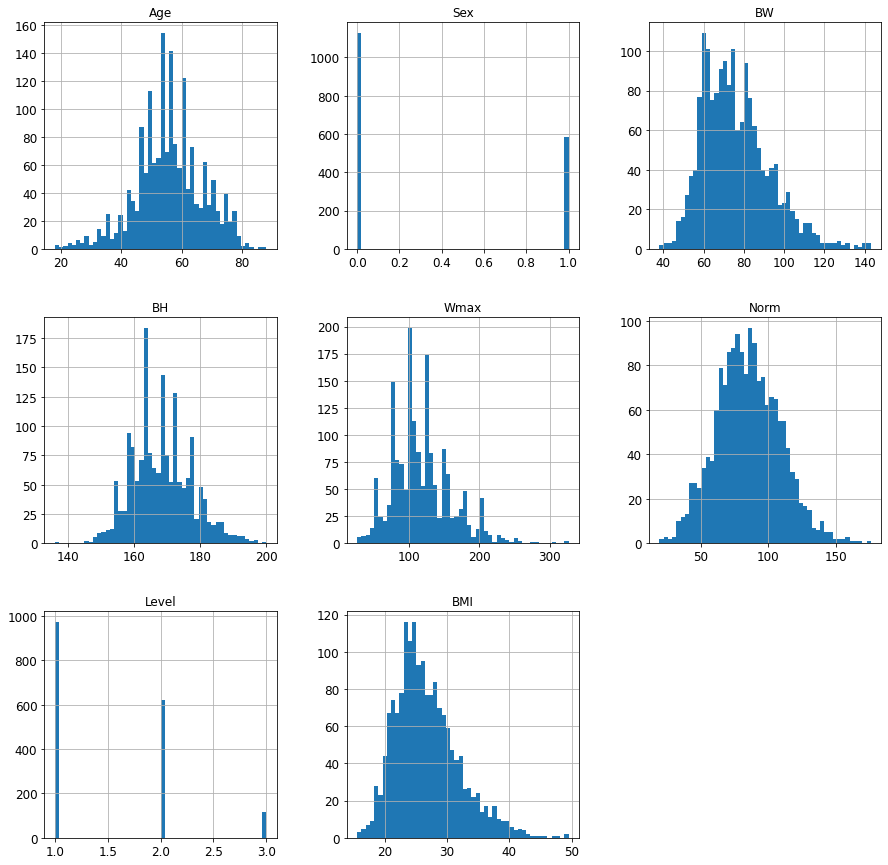

In [ ]:
df.hist(bins=50, figsize=(15,15))
plt.show()

In [ ]:
np.random.seed(42) # To ensure the repeatability of train/test results. It means that every time we run models the train/test samples will be same
del df['Norm']
del df['Type']
#del df['Level']
#del df['Gender']
#del df['BW']
#del df['BMI']
del df['Wmax'] # continuous

In [ ]:
#df=df.loc[df['Type'] == 'Brustkrebs']
#df=df.loc[df['Gender'] == 'W']
#df

# PREPARING TRAINING AND TEST SET

In [ ]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42) 
train_labels = train_set["Level"].copy()       # Save a copy of label variable
train_set = train_set.drop("Level", axis=1)    # Drop label variable from training set

In [ ]:
train_num = train_set.to_numpy()
train_num

array([[ 54.        ,   0.        ,  51.        , 168.        ,
         18.06972789],
       [ 63.        ,   1.        ,  84.        , 171.        ,
         28.72678773],
       [ 61.        ,   1.        ,  84.        , 170.        ,
         29.06574394],
       ...,
       [ 71.        ,   0.        ,  77.        , 160.        ,
         30.078125  ],
       [ 59.        ,   0.        ,  72.        , 175.        ,
         23.51020408],
       [ 55.        ,   0.        ,  73.        , 168.        ,
         25.86451247]])

# PIPELINE

### Training set

In [ ]:
# Pipline to scale numerical variables and transform categorical variable (gender) into binary

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

pipeline = Pipeline([
        ('std_scaler', MinMaxScaler()),])
train_prepared = pipeline.fit_transform(train_num)

In [ ]:
train_prepared # Only numerical variables were scaled (Age, BW, BH and BMI)

array([[0.51428571, 0.        , 0.12380952, 0.5       , 0.07368891],
       [0.64285714, 1.        , 0.43809524, 0.546875  , 0.38796343],
       [0.61428571, 1.        , 0.43809524, 0.53125   , 0.39795918],
       ...,
       [0.75714286, 0.        , 0.37142857, 0.375     , 0.42781409],
       [0.58571429, 0.        , 0.32380952, 0.609375  , 0.23412745],
       [0.52857143, 0.        , 0.33333333, 0.5       , 0.30355552]])

### Test set

In [ ]:
X_test = test_set.drop("Level", axis=1)
y_test = test_set["Level"].copy()
X_test_prepared = pipeline.fit_transform(X_test)

# SELECTING AND TRAINING THE MODEL

# Logistic Regression

### Optimization of k_neighbors in SMOTENC

In [ ]:
src = []
for k in range(2,93):
  for i in range(2,23):
    df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
    df = pd.DataFrame(df)
    df['Level']=np.where(df['Level']=="Bad",3,np.where(df['Level']=="Moderate",2,1))
    df['Sex']=np.where(df['Sex']=="W",0,1)
    def bmi(bw,bh):
      return bw/((bh/100)*(bh/100))
    df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 
    del df['Norm']
    del df['Type']
    del df['Wmax'] # continuous
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=42) 
    train_labels = train_set["Level"].copy()       # Save a copy of label variable
    train_set = train_set.drop("Level", axis=1)    # Drop label variable from training set
    train_num = train_set.to_numpy()
    pipeline = Pipeline([
          ('std_scaler', MinMaxScaler()),])
    train_prepared = pipeline.fit_transform(train_num)
    X_test = test_set.drop("Level", axis=1)
    y_test = test_set["Level"].copy()
    X_test_prepared = pipeline.fit_transform(X_test)
    sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=k, n_jobs=-1)
    train_prepared, train_labels = sm.fit_resample(train_prepared, train_labels)
    sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=i, n_jobs=-1)
    X_test_prepared, y_test = sm.fit_resample(X_test_prepared, y_test)
    log_reg = LogisticRegression(random_state=42, multi_class='auto', C=1, 
                  dual=False, fit_intercept=True,
                  intercept_scaling=5, l1_ratio=None, max_iter=100,
                  n_jobs=1, solver='liblinear', tol=0.001, verbose=0,
                  warm_start=True)
    log_reg.fit(train_prepared, train_labels) 

    final_predictions = log_reg.predict(X_test_prepared)
    scores = precision_recall_fscore_support(y_test, final_predictions, average='macro')
    x,y,z = scores[0],scores[1],scores[2]
    
    src.extend([[k,i,x,y,z]])


In [ ]:
my = pd.DataFrame(src)

my_max= my[4].idxmax()
my.loc[my_max]


0    44.000000
1    19.000000
2     0.526643
3     0.530225
4     0.511932
Name: 899, dtype: float64

### Over-sampling

In [ ]:
X, y = train_prepared, train_labels
print('Original dataset shape %s' % Counter(y))

sm = SMOTENC(random_state=42, categorical_features=[2, 1],k_neighbors=44, n_jobs=-1)

train_prepared, train_labels = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(train_labels))

Original dataset shape Counter({1: 780, 2: 496, 3: 93})
Resampled dataset shape Counter({1: 780, 3: 780, 2: 780})


In [ ]:
Z, q = X_test_prepared, y_test
print('Original dataset shape %s' % Counter(q))

sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=19, n_jobs=-1)

X_test_prepared, y_test = sm.fit_resample(X_test_prepared, y_test)
print('Resampled dataset shape %s' % Counter(y_test))

Original dataset shape Counter({1: 193, 2: 126, 3: 24})
Resampled dataset shape Counter({1: 193, 2: 193, 3: 193})


### Model

In [ ]:
log_reg = LogisticRegression(random_state=42, multi_class='auto', C=1, 
                   dual=False, fit_intercept=True,
                   intercept_scaling=5, l1_ratio=None, max_iter=100,
                   n_jobs=1, solver='liblinear', tol=0.001, verbose=0,
                   warm_start=True)
#sample_weights = np.array([4.9 if i == "Bad" else 0.92 if i == "Middle" else 0.59 for i in train_labels])
log_reg.fit(train_prepared, train_labels) #, sample_weight=sample_weights)

LogisticRegression(C=1, intercept_scaling=5, n_jobs=1, random_state=42,
                   solver='liblinear', tol=0.001, warm_start=True)

In [ ]:
final_predictions = log_reg.predict(X_test_prepared)

In [ ]:
print(log_reg.predict([[40, 1,85,180,27]]))

[3]


In [ ]:
# accuracy score (average of recalls across all three classes)
accuracy_score(y_test, final_predictions)

0.5302245250431779

In [ ]:
## K-fold cross-validation, with 10 folds
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

strf = StratifiedKFold(n_splits=10)
strf.get_n_splits(train_prepared, train_labels)

statistics.mean(cross_val_score(log_reg, train_prepared, train_labels, cv= strf,  scoring="accuracy"))

0.4777777777777778

In [ ]:
# PRECISION, RECALL AND F1 SCORE (Overall recall)

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, final_predictions, average='macro')
#'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance;

(0.5266434010294095, 0.5302245250431779, 0.5119319460217776, None)

### Hyperparameter optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {'multi_class':['auto', 'ovr', 'multinomial'],
     'C': [0.1, 0.5, 1],
     'max_iter': [100,500,1000],
     'penalty': ['l1', 'l2', 'elasticnet','none'], 
     'n_jobs': [1,3,5,7,9],
     'intercept_scaling': [0.1,0.5,1],
     'tol': [0.0001],
     'class_weight': ['balanced'],
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
  }]

model = LogisticRegression()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_lr = GridSearchCV(model, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_lr.fit(train_prepared, train_labels)

In [ ]:
grid_search_lr.best_params_

In [ ]:
grid_search_lr.best_estimator_

### Confusion matrix

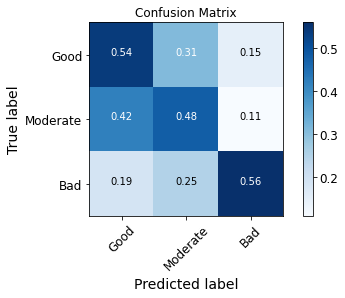

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


classes = [1, 2, 3]
cm = confusion_matrix(final_predictions, y_test, labels =classes, normalize='true') 
cm = np.around(cm, decimals=2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes_name = ["Good", "Moderate", "Bad"]
tick_marks = np.arange(len(classes_name))
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Support Vector Classifier

### Optimization of k_neighbors in SMOTENC

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_fscore_support

src = []
for k in range(2,93):
  for i in range(2,23):
    df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
    df = pd.DataFrame(df)
    df['Level']=np.where(df['Level']=="Bad",3,np.where(df['Level']=="Moderate",2,1))
    df['Sex']=np.where(df['Sex']=="W",0,1)
    def bmi(bw,bh):
      return bw/((bh/100)*(bh/100))
    df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 
    del df['Norm']
    del df['Type']
    del df['Wmax'] # continuous
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=42) 
    train_labels = train_set["Level"].copy()       # Save a copy of label variable
    train_set = train_set.drop("Level", axis=1)    # Drop label variable from training set
    train_num = train_set.to_numpy()
    pipeline = Pipeline([
          ('std_scaler', MinMaxScaler()),])
    train_prepared = pipeline.fit_transform(train_num)
    X_test = test_set.drop("Level", axis=1)
    y_test = test_set["Level"].copy()
    X_test_prepared = pipeline.fit_transform(X_test)
    sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=k, n_jobs=-1)
    train_prepared, train_labels = sm.fit_resample(train_prepared, train_labels)
    sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=i, n_jobs=-1)
    X_test_prepared, y_test = sm.fit_resample(X_test_prepared, y_test)
    svm_clf = SVC(gamma='scale', kernel='poly', coef0=1, degree =2, cache_size= 5, C=0.1, max_iter = -1, tol = 0.0001)
    svm_clf.fit(train_prepared, train_labels)

    final_predictions = svm_clf.predict(X_test_prepared)
    scores = precision_recall_fscore_support(y_test, final_predictions, average='macro')
    x,y,z = scores[0],scores[1],scores[2]
    
    src.extend([[k,i,x,y,z]])
    print(k,i, scores)


In [ ]:
my = pd.DataFrame(src)

my_max= my[2].idxmax()
my.loc[my_max]

0    72.000000
1    17.000000
2     0.550671
3     0.540587
4     0.517986
Name: 1485, dtype: float64

### Over-sampling

In [ ]:
X, y = train_prepared, train_labels
print('Original dataset shape %s' % Counter(y))

sm = SMOTENC(random_state=42, categorical_features=[2, 1],k_neighbors=72, n_jobs=-1)

train_prepared, train_labels = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(train_labels))

Original dataset shape Counter({1: 780, 2: 496, 3: 93})
Resampled dataset shape Counter({1: 780, 3: 780, 2: 780})


In [ ]:
Z, q = X_test_prepared, y_test
print('Original dataset shape %s' % Counter(q))

sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=19, n_jobs=-1)

X_test_prepared, y_test = sm.fit_resample(X_test_prepared, y_test)
print('Resampled dataset shape %s' % Counter(y_test))

Original dataset shape Counter({1: 193, 2: 126, 3: 24})
Resampled dataset shape Counter({1: 193, 2: 193, 3: 193})


### Model

In [ ]:
from sklearn.svm import SVC
svm_clf = SVC(gamma='scale', kernel='poly', coef0=1, degree =9, cache_size= 5, C=0.1, max_iter = -1, tol = 0.0001)
svm_clf.fit(train_prepared, train_labels)

SVC(C=0.1, cache_size=5, coef0=1, degree=9, kernel='poly', tol=0.0001)

In [ ]:
print(svm_clf.predict([[40, 1,85,180,27]]))

[1]


In [ ]:
final_predictions = svm_clf.predict(X_test_prepared)

In [ ]:
accuracy_score(y_test, final_predictions)

0.6407599309153713

In [ ]:
## K-fold cross-validation, with 10 folds
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

strf = StratifiedKFold(n_splits=10)
strf.get_n_splits(train_prepared, train_labels)

statistics.mean(cross_val_score(svm_clf, train_prepared, train_labels, cv= strf,  scoring="accuracy"))

In [ ]:
# PRECISION, RECALL AND F1 SCORE

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, final_predictions, average='macro')
#'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance;

(0.6479773120994495, 0.6407599309153713, 0.6333148002285749, None)

### Hyperparameter optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {#'multi_class':['ovr'],
     'C': [0.5],
     'cache_size': [10],
     'coef0': [1], 
     'degree': [5],
     'gamma': ['scale'],
     'kernel': ['poly'],
     'max_iter': [-1],
     'tol': [0.1,0.5,1]
  }]

model = SVC()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_svc = GridSearchCV(model, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_svc.fit(train_prepared, train_labels)

In [ ]:
grid_search_svc.best_params_

In [ ]:
grid_search_svc.best_estimator_

### Confusion matrix

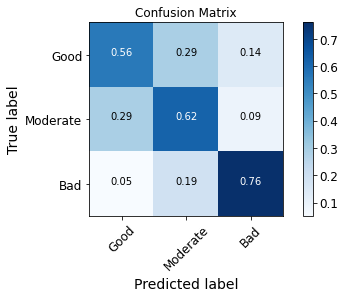

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


classes = [1, 2, 3]
cm = confusion_matrix(final_predictions, y_test, labels =classes, normalize='true') 
cm = np.around(cm, decimals=2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes_name = ["Good", "Moderate", "Bad"]
tick_marks = np.arange(len(classes_name))
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Random Forest Classifier

### Optimization of k_neighbors in SMOTENC

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support

src = []
for k in range(2,93):
  for i in range(2,23):
    df = pd.read_excel('/content/drive/MyDrive/Data.xlsx')
    df = pd.DataFrame(df)
    df['Level']=np.where(df['Level']=="Bad",3,np.where(df['Level']=="Moderate",2,1))
    df['Sex']=np.where(df['Sex']=="W",0,1)
    def bmi(bw,bh):
      return bw/((bh/100)*(bh/100))
    df['BMI']=bmi(df.iloc[:,2],df.iloc[:,3]) 
    del df['Norm']
    del df['Type']
    del df['Wmax'] # continuous
    train_set, test_set = train_test_split(df, test_size=0.2, random_state=42) 
    train_labels = train_set["Level"].copy()       # Save a copy of label variable
    train_set = train_set.drop("Level", axis=1)    # Drop label variable from training set
    train_num = train_set.to_numpy()
    pipeline = Pipeline([
          ('std_scaler', MinMaxScaler()),])
    train_prepared = pipeline.fit_transform(train_num)
    X_test = test_set.drop("Level", axis=1)
    y_test = test_set["Level"].copy()
    X_test_prepared = pipeline.fit_transform(X_test)
    sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=k, n_jobs=-1)
    train_prepared, train_labels = sm.fit_resample(train_prepared, train_labels)
    sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=i, n_jobs=-1)
    X_test_prepared, y_test = sm.fit_resample(X_test_prepared, y_test)
    forest_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=150, n_jobs=-1,random_state=42,
                                    bootstrap= True, ccp_alpha = 0.0, criterion = 'entropy', min_impurity_decrease = 0.0, 
                                    min_samples_leaf = 150, min_samples_split = 3)
    forest_clf.fit(train_prepared, train_labels)

    final_predictions = forest_clf.predict(X_test_prepared)
    scores = precision_recall_fscore_support(y_test, final_predictions, average='macro')
    x,y,z = scores[0],scores[1],scores[2]
    
    src.extend([[k,i,x,y,z]])
    print(k,i, scores)

In [ ]:
my = pd.DataFrame(src)

my_max= my[2].idxmax()
my.loc[my_max]

0    68.000000
1    16.000000
2     0.507178
3     0.512953
4     0.509327
Name: 1400, dtype: float64

### Over-samplimg

In [ ]:
X, y = train_prepared, train_labels
print('Original dataset shape %s' % Counter(y))

sm = SMOTENC(random_state=42, categorical_features=[2, 1],k_neighbors=68, n_jobs=-1)

train_prepared, train_labels = sm.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(train_labels))

Original dataset shape Counter({1: 780, 2: 496, 3: 93})
Resampled dataset shape Counter({1: 780, 3: 780, 2: 780})


In [ ]:
Z, q = X_test_prepared, y_test
print('Original dataset shape %s' % Counter(q))

sm = SMOTENC(random_state=42, categorical_features=[2, 1], k_neighbors=16, n_jobs=-1)

X_test_prepared, y_test = sm.fit_resample(X_test_prepared, y_test)
print('Resampled dataset shape %s' % Counter(y_test))

Original dataset shape Counter({1: 193, 2: 126, 3: 24})
Resampled dataset shape Counter({1: 193, 2: 193, 3: 193})


### Model

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=300, max_leaf_nodes=150, n_jobs=-1,random_state=42,
                                    bootstrap= True, ccp_alpha = 0.0, criterion = 'entropy', min_impurity_decrease = 0.0, 
                                    min_samples_leaf = 150, min_samples_split = 3)
forest_clf.fit(train_prepared, train_labels)


RandomForestClassifier(criterion='entropy', max_leaf_nodes=150,
                       min_samples_leaf=150, min_samples_split=3,
                       n_estimators=300, n_jobs=-1, random_state=42)

In [ ]:
final_predictions = forest_clf.predict(X_test_prepared)

In [ ]:
print(forest_clf.predict([[40, 1,85,180,27]]))

[2]


In [ ]:
# accuracy score (average of recalls across all three classes)
#sample_weights = np.array([4.9 if i == "Bad" else 0.92 if i == "Middle" else 0.59 for i in y_test])
accuracy_score(y_test, final_predictions)

0.5129533678756477

In [ ]:
## K-fold cross-validation, with 10 folds
import statistics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

strf = StratifiedKFold(n_splits=10)
strf.get_n_splits(train_prepared, train_labels)

statistics.mean(cross_val_score(forest_clf, train_prepared, train_labels, cv= strf,  scoring="accuracy"))

0.5692307692307692

In [ ]:
# PRECISION, RECALL AND F1 SCORE

from sklearn.metrics import precision_recall_fscore_support
precision_recall_fscore_support(y_test, final_predictions, average='macro')
#'weighted': Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). This alters ‘macro’ to account for label imbalance;

(0.50717781555477, 0.5129533678756476, 0.5093273139690314, None)

### Hyperparameter optimization

In [ ]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

param_grid = [
    
    {'ccp_alpha': [0.0],
     'min_impurity_decrease': [0.0],
     'bootstrap': [True],
     #'max_iter': [-1],
     'n_estimators': [300],
     'criterion': ['entropy'],
     'max_leaf_nodes': [150],
     'min_samples_leaf': [150], 
     'min_samples_split': [3]

  }]

model = RandomForestClassifier()
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search_rf = GridSearchCV(model, param_grid, cv=10,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search_rf.fit(train_prepared, train_labels)

In [ ]:
grid_search_rf.best_params_

In [ ]:
grid_search_rf.best_estimator_

### Confusion matrix

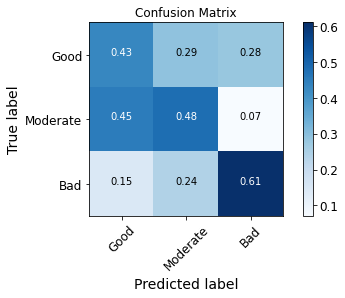

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np


classes = [1, 2, 3]
cm = confusion_matrix(final_predictions, y_test, labels =classes, normalize='true') 
cm = np.around(cm, decimals=2)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

classes_name = ["Good", "Moderate", "Bad"]
tick_marks = np.arange(len(classes_name))
plt.xticks(tick_marks, classes_name, rotation=45)
plt.yticks(tick_marks, classes_name)

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Feature importances

In [ ]:
feature_importances = forest_clf.feature_importances_
feature_importances

array([0.1091378 , 0.17008772, 0.51642713, 0.04899008, 0.15535728])

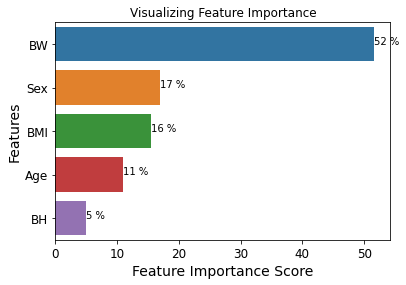

In [ ]:
import seaborn as sns

df2 = df.drop("Level", axis=1)
feature_names = list(df2.columns)
feature_imp = pd.Series(feature_importances,index=feature_names).sort_values(ascending=False)
sns.barplot(x=feature_imp*100, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Feature Importance")
for index, value in enumerate(feature_imp*100):
    plt.text(value, index, str("{:.0f}".format(value)+" %")) # Rounding the float
plt.show()

### ROC curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

n_classes = train_labels.shape[1]

classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"], # weighted
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Voting Classifiers

In [ ]:
from sklearn.ensemble import VotingClassifier

In [ ]:
log_clf = log_reg
rnd_clf = forest_clf
svm_clf = svm_clf
voting_clf = VotingClassifier(
estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],voting='hard')
voting_clf.fit(train_prepared, train_labels)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1, intercept_scaling=5,
                                                 multi_class='ovr', n_jobs=1,
                                                 random_state=42,
                                                 solver='liblinear', tol=0.001,
                                                 warm_start=True)),
                             ('rf',
                              RandomForestClassifier(criterion='entropy',
                                                     max_leaf_nodes=150,
                                                     min_samples_leaf=150,
                                                     min_samples_split=3,
                                                     n_estimators=300,
                                                     n_jobs=-1,
                                                     random_state=42)),
                             ('svc',
                     

In [ ]:
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(train_prepared, train_labels)
  y_pred = clf.predict(X_test_prepared)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.4784110535405872
RandomForestClassifier 0.4525043177892919
SVC 0.5595854922279793
VotingClassifier 0.5215889464594128
